In [1]:
import numpy as np
import random
import sys
from typing import Callable

%load_ext autoreload
%autoreload 2

sys.path.append('src')
from src.generator.Generator import Generator
from src.generator.History import History

## Description
The following are a few examples and tests with the Generator class.

## Simple cases

### Instant action

,E1,E2,E3
0,1,0,1
1,1,1,1
2,0,0,0


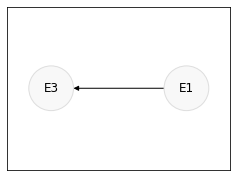

In [2]:
random.seed(12)

event_function: Callable[[History], float] = lambda history: \
    1 if history.get_event(1) == 1 else 0

dataset = Generator() \
    .add_discrete() \
    .add_discrete() \
    .add_function(event_function)

display(dataset.generate().astype(int))

dataset.plot_relations()

### Random samples

,E1,E2,E3
0,5,8,11
1,5,2,10
2,8,3,17


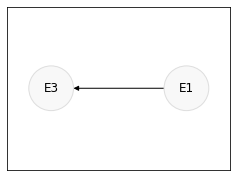

In [3]:
random.seed(10)

event_function: Callable[[History], float] = lambda history: \
    2 * history.get_event()

dataset = Generator() \
    .add_uniform() \
    .add_uniform() \
    .add_function(event_function)

display(dataset.generate().astype(int))

dataset.plot_relations()

### Logs like

,E1,E2,E3
0,1.0,NaN,NaN
1,NaN,1.0,NaN
2,NaN,NaN,1.0


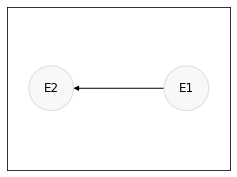

In [4]:
random.seed(1)

event_function: Callable[[History], float] = lambda history: \
    1 if history.get_event() == 1 else None

dataset = Generator(sequential=True) \
    .add_discrete(data_type=float) \
    .add_function(event_function) \
    .add_discrete(data_type=float)

display(dataset.generate())

dataset.plot_relations()

### Sensors reads

,E1,E2,E3
0,7.0,NaN,NaN
1,NaN,3.0,NaN
2,NaN,NaN,17.0


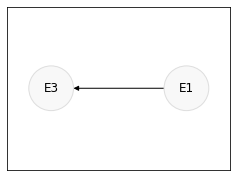

In [5]:
random.seed(14)

event_function: Callable[[History], float] = lambda history: \
    2 * history.get_event(delay=1) + 3

dataset = Generator(sequential=True) \
    .add_uniform(round=0) \
    .add_uniform(round=0) \
    .add_function(event_function, round=0)

display(dataset.generate())

dataset.plot_relations()

### Pattern search

,E1,T
0,-1,1526242500
1,0,1526242800
2,1,1526243100
3,0,1526243400
4,-1,1526243700
5,0,1526244000


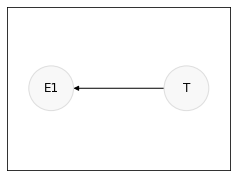

In [6]:
event_function: Callable[[History], float] = lambda history: \
    np.sin(history.get_timestamp() / 60 / 5 * np.pi / 2)

dataset = Generator() \
    .add_function(event_function) \
    .set_time('2018-05-13 20:15', step='5m')

display(dataset.generate(6).astype(int))

dataset.plot_relations()

### Date noise

,E1,T
0,0.2,1.287605e+09
1,1.0,1.287608e+09
2,-0.2,1.287612e+09
3,-1.0,1.287616e+09
4,-0.3,1.287619e+09
5,1.0,1.287622e+09


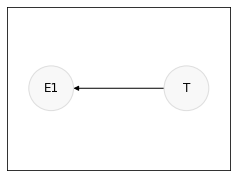

In [7]:
random.seed(1)

event_function: Callable[[History], float] = lambda history: \
    np.sin(history.get_timestamp() / 60 / 60 * np.pi / 2)

dataset = Generator() \
    .add_function(event_function) \
    .set_time('2010-10-20 20:00', step='1h', precision='10m')

display(dataset.generate(6).round(1))

dataset.plot_relations()

### With delay

,E1,E2
0,3,0
1,1,0
2,3,6
3,2,2
4,2,6
5,3,4


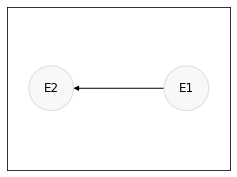

In [8]:
random.seed(5)

event_function: Callable[[History], float] = lambda history: \
    2 * history.get_event(delay=2, null_value=0)

dataset = Generator() \
    .add_uniform(1, 3, round=0) \
    .add_function(event_function, round=0)

display(dataset.generate(6).astype(int))

dataset.plot_relations()

## Multiple causes

,E1,E2,E3
0,5,8,13
1,5,2,7
2,8,3,12


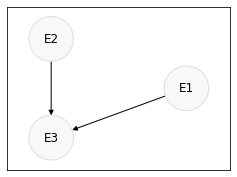

In [9]:
random.seed(10)

event_function: Callable[[History], float] = lambda history: \
    history.get_event(1) + history.get_event(2)

dataset = Generator() \
    .add_uniform() \
    .add_uniform() \
    .add_function(event_function)

display(dataset.generate().astype(int))

dataset.plot_relations()

### Shadow causes

,E2,E3
0,8,13
1,2,7
2,3,12


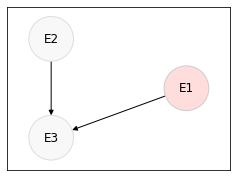

In [10]:
random.seed(10)

event_function: Callable[[History], float] = lambda history: \
    history.get_event(1) + history.get_event(2)

dataset = Generator() \
    .add_uniform(shadow=True) \
    .add_uniform() \
    .add_function(event_function)

display(dataset.generate().astype(int))


dataset.plot_relations()

### Multiple effects

,E1,E2,E3
0,3,6,4
1,8,16,9
2,8,16,9


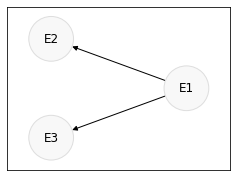

In [11]:
random.seed(3)

dataset = Generator() \
    .add_uniform() \
    .add_function(lambda history: int(history.get_event()) * 2) \
    .add_function(lambda history: history.get_event() + 1)

display(dataset.generate().astype(int))

dataset.plot_relations()

## Sales history dataset
### Day of the week

In [12]:
def week_day(history: History) -> float:
    day = history.get_datetime().weekday()
    ratios = [20, 20, 15, 5, 0, -20, -30]
    return 1 + ratios[day] / 100

def sales(history: History) -> float:
    return history.get_event(1) * history.get_event(2)

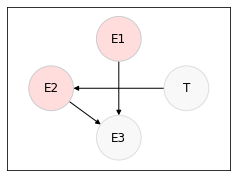

<AxesSubplot:xlabel='T'>

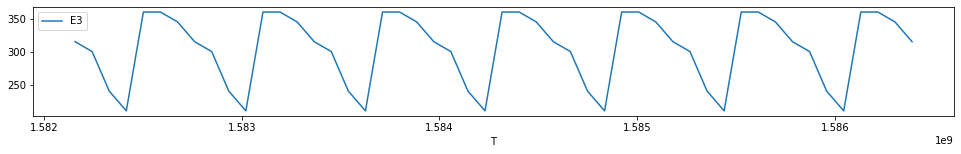

In [13]:
dataset = Generator() \
    .set_time('2020-02-20', step='1d') \
    .add_constant(300, shadow=True) \
    .add_function(week_day, shadow=True) \
    .add_function(sales)

dataset.plot_relations()
dataset.generate(50).plot(x='T', y='E3', figsize=(16.5,2))

### Random base sales

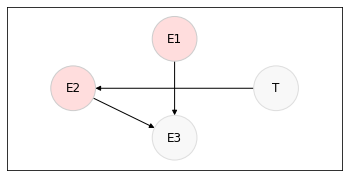

<AxesSubplot:xlabel='T'>

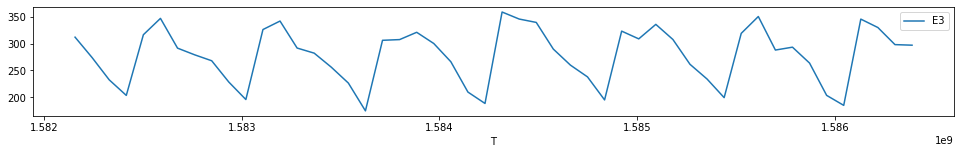

In [14]:
dataset = Generator() \
    .set_time('2020-02-20', step='1d') \
    .add_uniform(250, 300, shadow=True) \
    .add_function(week_day, shadow=True) \
    .add_function(sales)

dataset.plot_relations(fig_size=(6, 3))
dataset.generate(50).plot(x='T', y='E3', figsize=(16.5,2))

### Weekly sales increase

In [15]:
def year_week(history: History) -> float:
    week = history.get_datetime().isocalendar()[1]
    ratio = week - history.get_datetime(-1).isocalendar()[1]
    return 1 + ratio / 5

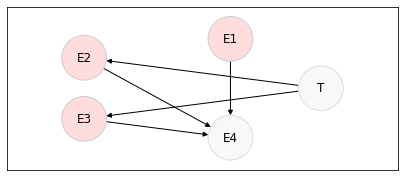

<AxesSubplot:xlabel='T'>

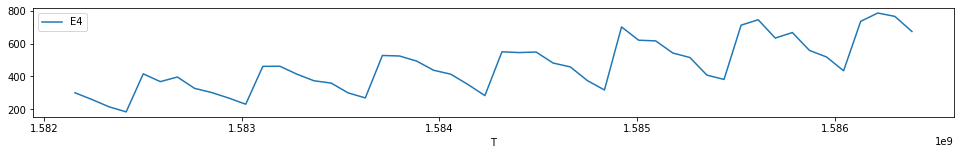

In [16]:
dataset = Generator() \
    .set_time('2020-02-20', step='1d') \
    .add_uniform(250, 300, shadow=True) \
    .add_function(week_day, shadow=True) \
    .add_function(year_week, shadow=True) \
    .add_function(lambda h: h.get_event(1) * h.get_event(2) * h.get_event(3))

dataset.plot_relations(fig_size=(7,3))
dataset.generate(50).plot(x='T', y='E4', figsize=(16.5,2))

### Marketing campaigns

In [17]:
def promo(history: History) -> float:
    value = 0
    if history.get_event(4, delay=1):
        value = random.normal(500, 100, 1)
    if history.get_event(4, delay=2):
        value = 400 + random.uniform(-100, 100)
    if history.get_event(4, delay=3):
        value = 200 + random.uniform(-50, 50)

    return value

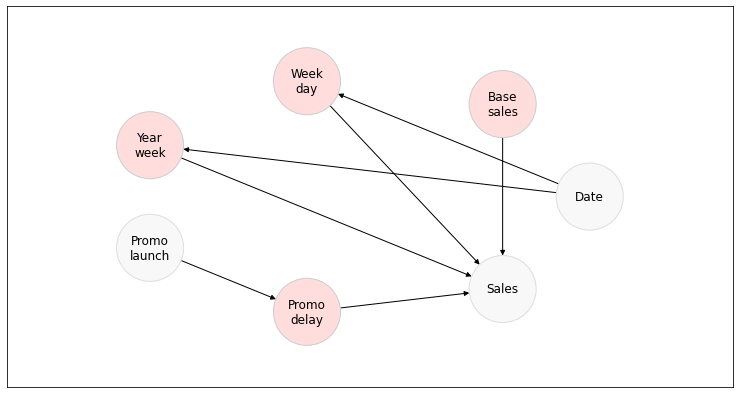

,Date,E6,Promo launch,Sales
0,1.582157e+09,4325.782710,nan,309
1,1.582243e+09,2600.323013,nan,257
2,1.582330e+09,4992.323396,nan,201
3,1.582416e+09,4648.753702,nan,181
4,1.582502e+09,4648.935921,nan,396


<AxesSubplot:xlabel='Date'>

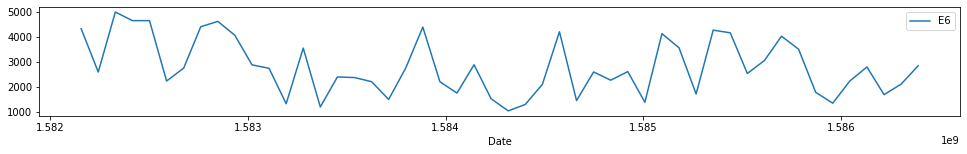

In [22]:
from datasets.integration.SalesDataset import SalesDataset

dataset = SalesDataset.marketing_campaigns().get_generator()

dataset.plot_relations(fig_size=(13,7), node_size=45)
dataframe = dataset.generate(50)
display(dataframe.head())

time_label=dataset.get_events()[0].label
data_label=dataset.get_events()[6].label
dataframe.plot(x=time_label, y=data_label, figsize=(16.5,2))

# Gene expression dataset

In [19]:
def pathology(history: History) -> float:
    gene1 = history.get_event(1) > 0.8
    gene2 = history.get_event(2) > 0.7
    gene5 = history.get_event(5) > 0.6

    return gene1 and gene2 or gene5

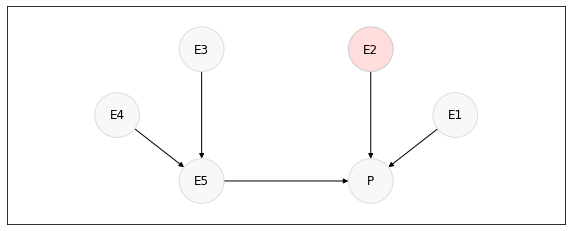

,E1,E3,E4,E5,E6,E7,P
0,0.390780,0.263319,0.001979,0.132649,0.170830,0.518239,0.0
1,0.802176,0.667417,0.224586,0.446001,0.345306,0.415865,1.0
2,0.545521,0.026497,0.196461,0.111479,0.761919,0.662332,0.0
3,0.308424,0.099724,0.582002,0.340863,0.126122,0.168177,0.0
4,0.499494,0.414190,0.473550,0.443870,0.869036,0.047933,0.0


<AxesSubplot:>

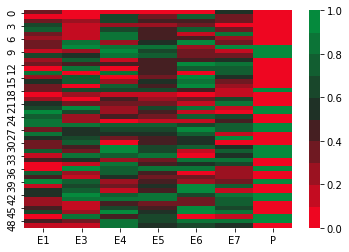

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

dataset = Generator() \
    .add_uniform(0, 1) \
    .add_uniform(0, 1, shadow=True) \
    .add_uniform(0, 1) \
    .add_uniform(0, 1) \
    .add_function(lambda h: (h.e(3) + h.e(4))/2) \
    .add_uniform(0, 1) \
    .add_uniform(0, 1) \
    .add_function(pathology, label='P')

dataset.plot_relations(fig_size=(10,4))

display(dataset.generate(5))

cmap = sns.diverging_palette(11, 135, s=99, n=10, center="dark")
sns.heatmap(dataset.generate(50), cmap=cmap)